# Apply thresholding on Sentinel-1 and extract shorelines (for comparison with supervised results)

## Load packages

In [1]:
%matplotlib inline

import os
os.environ['USE_PYGEOS'] = '0'
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from dea_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.raster import tide_cutoffs,load_tidal_subset
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.morphology import binary_closing, disk,diameter_closing
from datacube.utils.cog import write_cog

import itertools
import pickle

import warnings
warnings.filterwarnings("ignore")

from modules import lee_filter,filter_by_tide_height,load_s1_by_orbits,process_features_s1,collect_training_samples

## Set up a Dask cluster

In [2]:
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35445,Workers: 1
Dashboard: /user/whusggliuqx@gmail.com/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:43671,Total threads: 4
Dashboard: /user/whusggliuqx@gmail.com/proxy/45051/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:46817,


## Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Sentinel-1 thresholding and shoreline extraction")

In [4]:
# Define areas of interest: Madagarscar,Comoros
locations={'Madagascar_west':(-17.474,43.924),
           'Madagascar_south':(-25.572,45.538),
           'Tanzania':(-6.32,39.280),
           'Kenya':(-4.025,39.725),
           'Comoros':(-12.4,43.736)
          }
location_name=list(locations.keys())[0]
location=locations[location_name]
lat=location[0]
lon=location[1]

# Combine central lat,lon with buffer to get area of interest
buffer = 0.04
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to apply orbit filtering
s1_orbit_filtering=True

# whether to implement Lee filtering on Sentinel-1 data
lee_filtering=False

# Lee filtering size
filter_size=2

# maximum number of samples per location
max_samples=10000

## View the selected location

In [5]:
display_map(x=lon_range, y=lat_range)

## Load and process Sentinel-1 data

In [6]:
# query S1 data
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vh','vv','mask','area','angle'], # loading vh for experiement
    'resolution': (-20, 20),
    'output_crs':"EPSG:6933",
    'group_by':'solar_day',
    'dask_chunks':{'time': 1}
}

# load s1 by orbit
S1=load_s1_by_orbits(dc,query)

# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-1...')
S1_filtered=filter_by_tide_height(S1,tide_centre=0.0)

# preprocess S1 and extract features
ds_summaries_s1=process_features_s1(S1_filtered,filter_size=filter_size,
                                s1_orbit_filtering=s1_orbit_filtering,time_step=time_step)


Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 145 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 146/146 [00:00<00:00, 173.45it/s]


Applying Lee filtering using filtering size of 2 pixels...

Filtering Sentinel-1 product by orbit...


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Calculating features for Sentinel-1
Generate temporal composites...


## Load and process Sentinel-2 data

In [7]:
# query S2
print('\nQuerying Sentinel-2 data...')
query.update({'measurements': ['red', 'green', 'blue', 'swir_1','nir']})
S2 = load_ard(dc=dc,
              products=['s2_l2a'],
              resampling='bilinear',
              min_gooddata=0.8,
              align=(10, 10),
              mask_filters=[("opening", 2), ("dilation", 5)],
              **query)

# Calculate S2 water index
S2 = calculate_indices(S2, index='MNDWI', satellite_mission='s2')

# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-2...')
S2_filtered=filter_by_tide_height(S2,tide_centre=0.0)

# median of S2
ds_summaries_s2 = (S2_filtered
                .resample(time=time_step)
                .median('time')
                .compute()
                    )


Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 198 out of 288 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 198 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 198/198 [00:01<00:00, 177.66it/s]


In [12]:
# generate training samples using S2
s1_median_vh,labels=collect_training_samples(S2_filtered,ds_summaries_s1.vh_med.to_dataset(),time_step,max_samples)



Calculating simplified coastal zone mask...

Applying buffering of 10 Sentinel-2 pixels (parameter buffer_pixels)...
Number of samples available:  168048


# Rename time as year

In [13]:
ds_summaries_s1['time'] = ds_summaries_s1.time.dt.year
ds_summaries_s1 = ds_summaries_s1.rename(time='year')

print(ds_summaries_s1)
# Rename each image by year
ds_summaries_s2['time'] = ds_summaries_s2.time.dt.year
ds_summaries_s2 = ds_summaries_s2.rename(time='year')

print(ds_summaries_s2)

<xarray.Dataset>
Dimensions:      (year: 4, y: 489, x: 387)
Coordinates:
  * y            (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x            (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref  int32 6933
  * year         (year) int64 2018 2019 2020 2021
Data variables: (12/18)
    vh_med       (year, y, x) float32 -34.18 -35.5 -34.43 ... -16.61 -17.03
    vv_med       (year, y, x) float32 -19.75 -19.24 -18.94 ... -11.41 -11.38
    vv_a_vh_med  (year, y, x) float32 -55.29 -56.5 -54.33 ... -27.91 -28.21
    vv_m_vh_med  (year, y, x) float32 13.91 15.63 15.26 ... 5.151 5.125 5.874
    area_med     (year, y, x) float32 1.21 1.21 1.209 ... 1.217 1.203 1.176
    angle_med    (year, y, x) float64 40.0 40.0 40.0 40.0 ... 40.0 40.0 41.0
    ...           ...
    vv_a_vh_max  (year, y, x) float32 -44.65 -42.64 -42.9 ... -20.77 -22.04
    vv_m_vh_max  (year, y, x) float32 33.63 32.24 31.55 ... 8.666 7.49 8.334
    vh_min       (year, y, x) float32 -5

## Plot temporal composites

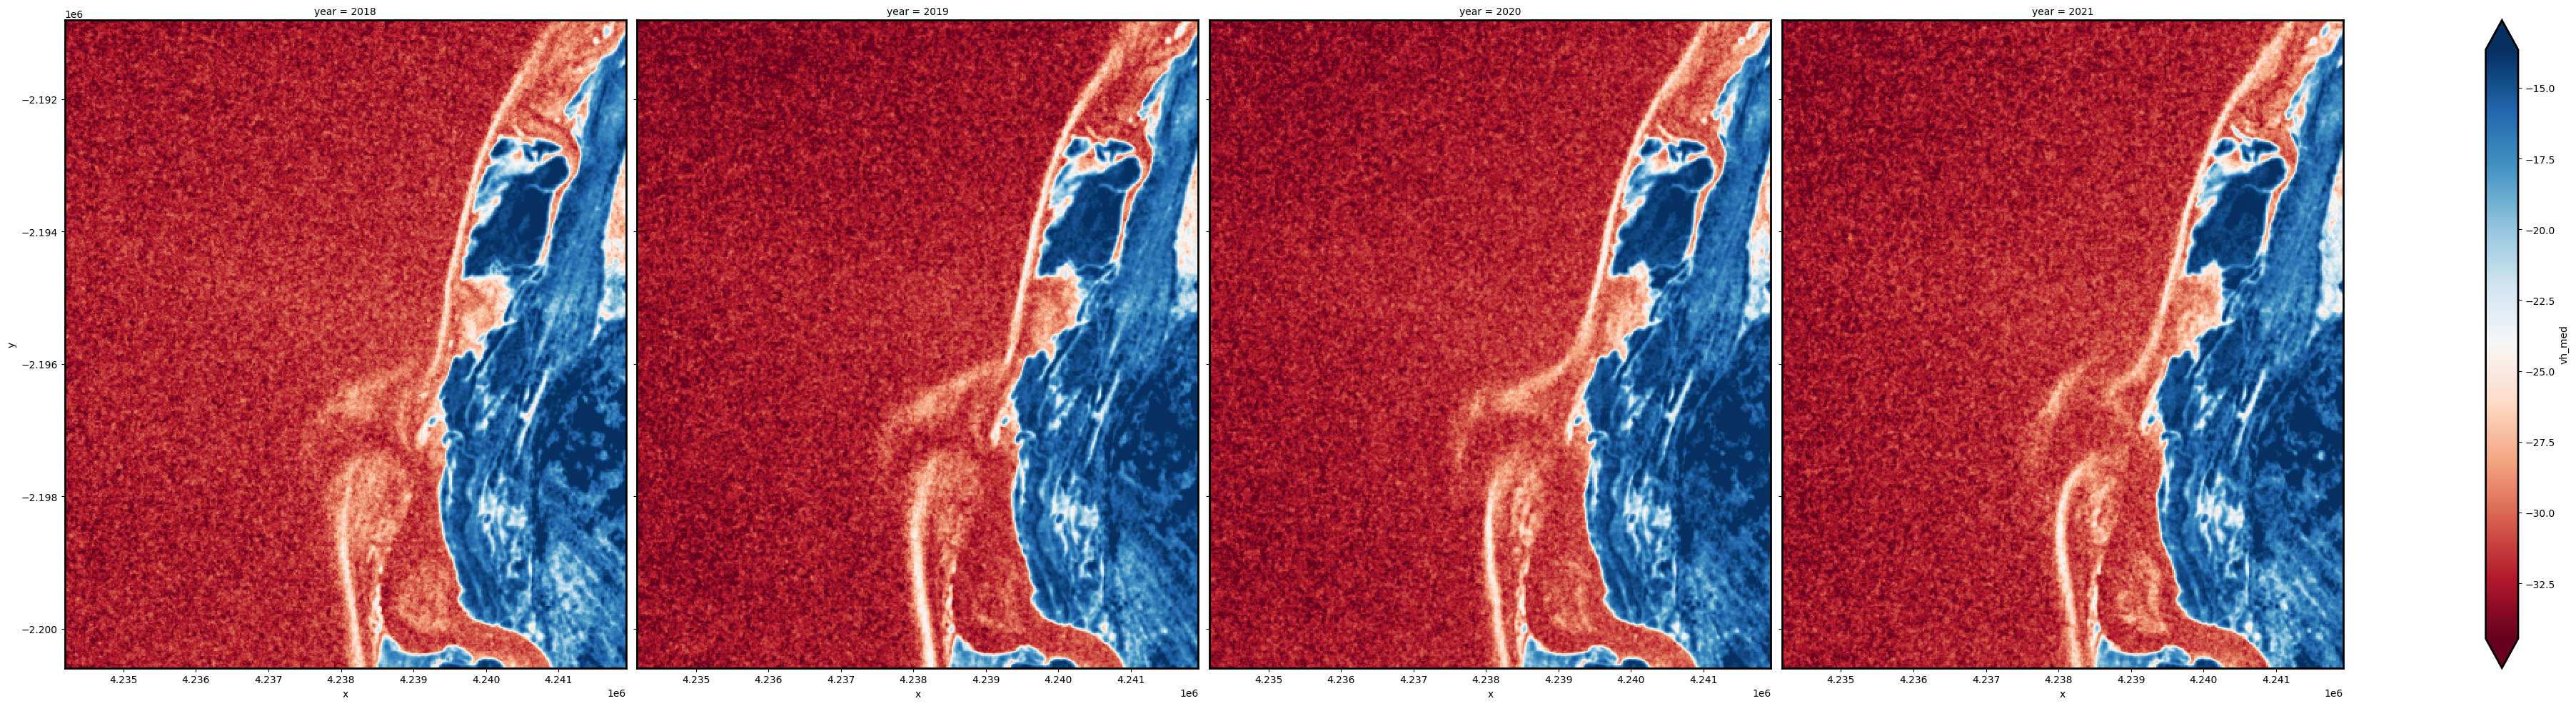

In [14]:
# Plot vh
ds_summaries_s1.vh_med.plot(col='year',
                       cmap='RdBu',
                       col_wrap=4,
                       robust=True, size=10)
plt.savefig('s1_annual_medians_vh_{}.png'.format(location_name))

In [ ]:
# Plot Sentinel-2
# ds_summaries_s2.MNDWI.plot(col='year',
#                        cmap='RdBu',
#                        col_wrap=4,
#                        robust=True, size=10)
rgb(ds_summaries_s2, col='year')
plt.savefig('s2_annual_medians_rgb_{}.png'.format(location_name))

## Thresholding of Sentinel-1 data

### Automatic identification of optimal threshold

In [16]:
# minimum thresholding
threshold = threshold_minimum(ds_summaries_s1.vh_med.values[~np.isnan(ds_summaries_s1.vh_med.values)])
# otsu thresholding
threshold_o = threshold_otsu(ds_summaries_s1.vh_med.values[~np.isnan(ds_summaries_s1.vh_med.values)])
print('threshold identified by minimum thresholding method: ',threshold)
print('threshold identified by otsu thresholding method: ', threshold_o)

threshold identified by minimum thresholding method:  -23.402588
threshold identified by otsu thresholding method:  -24.172955


### Identify optimal threshold using training pixels and ROC

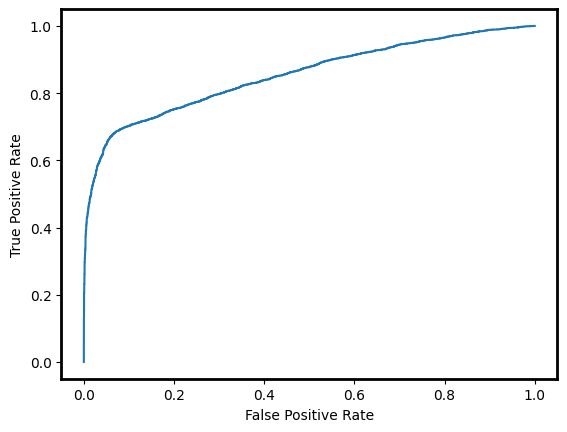

In [20]:
fpr, tpr, thresholds  = roc_curve(labels, s1_median_vh, pos_label=0)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [21]:
optim_idx = np.argmax(tpr - fpr)
threshold_roc = thresholds[optim_idx]
print('The optimal threshold is,',threshold_roc)

The optimal threshold is, -24.206406


### Plot classification results from automatic thresholding

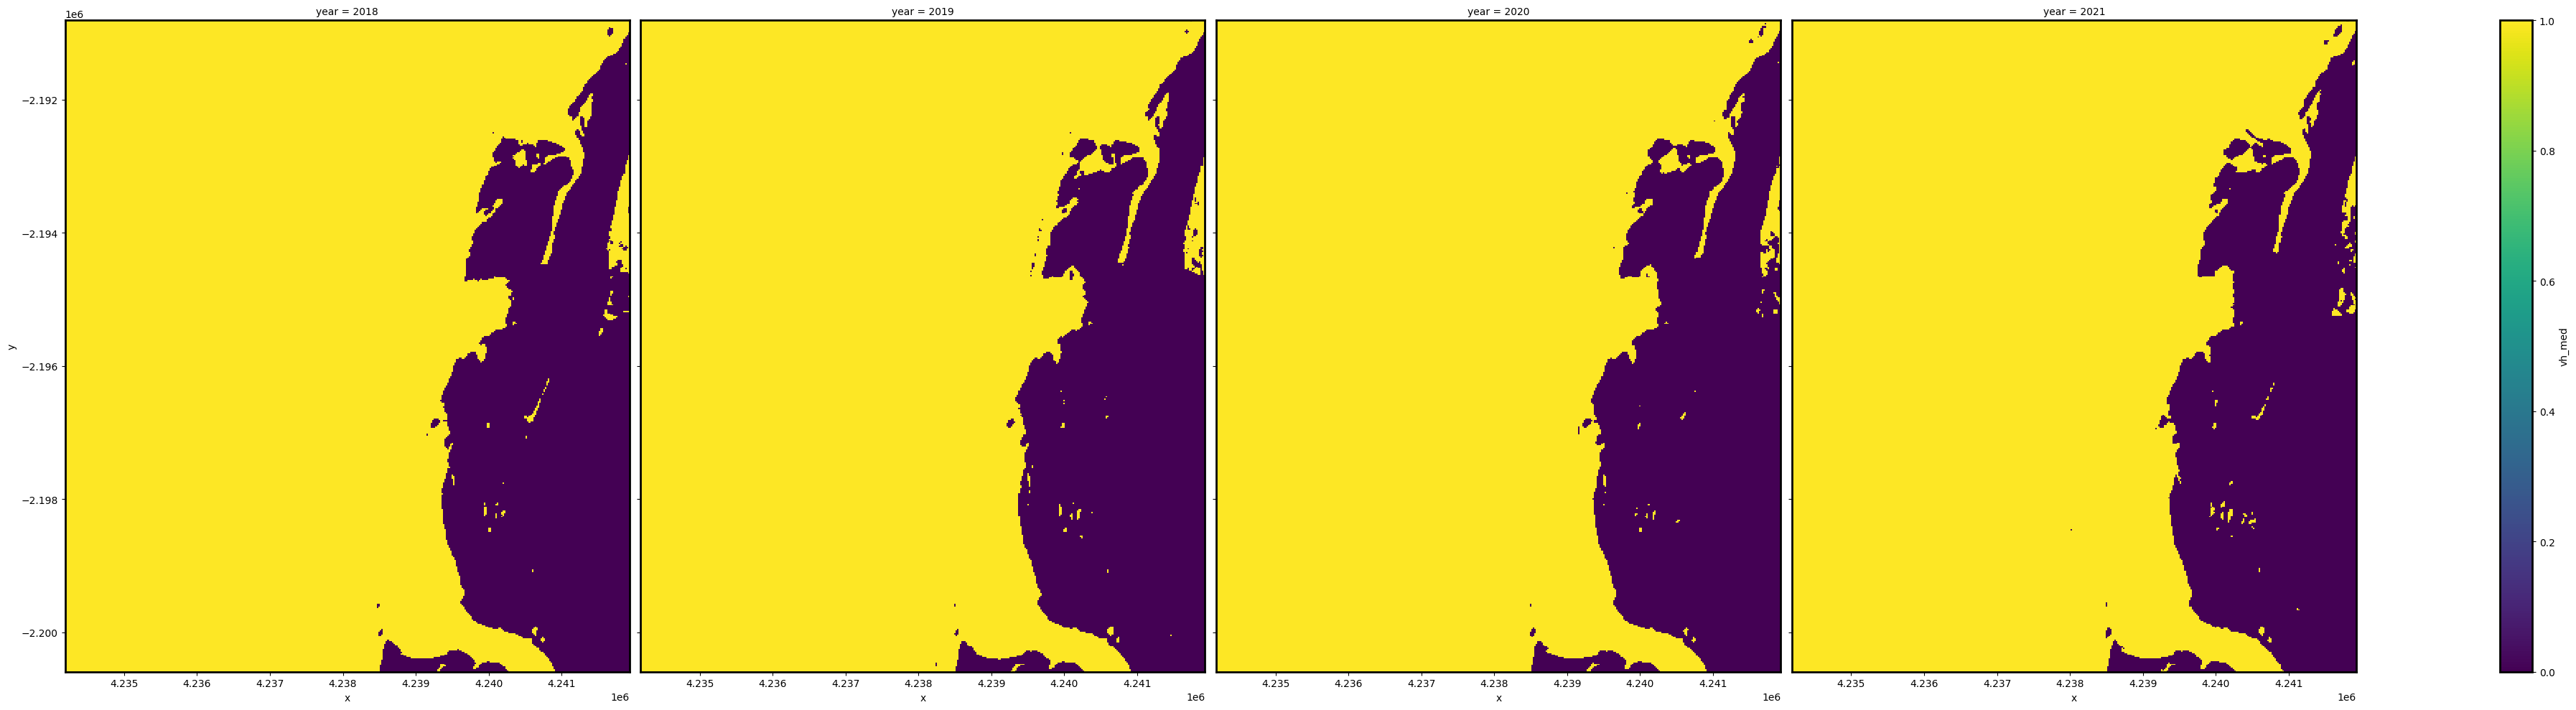

In [22]:
ds_summaries_s1_thresholded=ds_summaries_s1.vh_med<=threshold
ds_summaries_s1_thresholded.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)
plt.savefig('thresholding_s1_{}.png'.format(location_name))

### Plot classification results from optimal ROC threshold

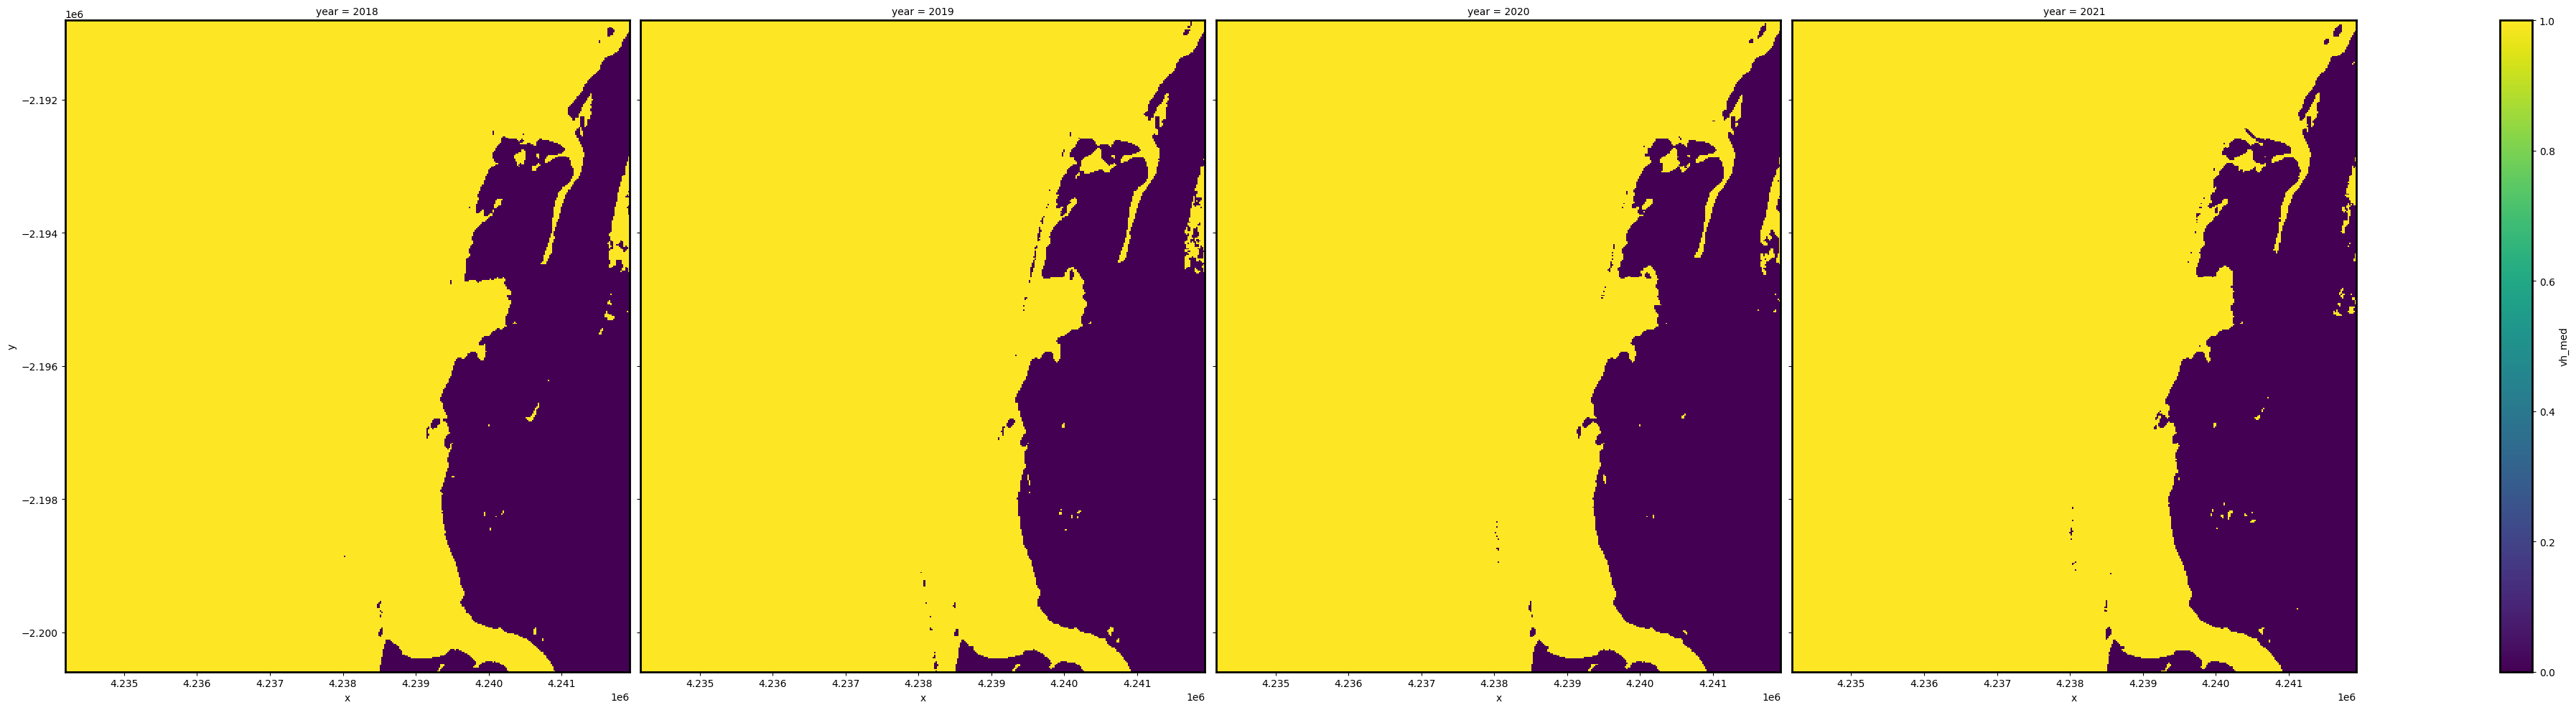

In [23]:
s1_roc_thresholded=ds_summaries_s1.vh_med<=threshold_roc
s1_roc_thresholded.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)
plt.savefig('thresholding_roc_s1_{}.png'.format(location_name))

### Plot Sentinel-2 classification results (as reference)

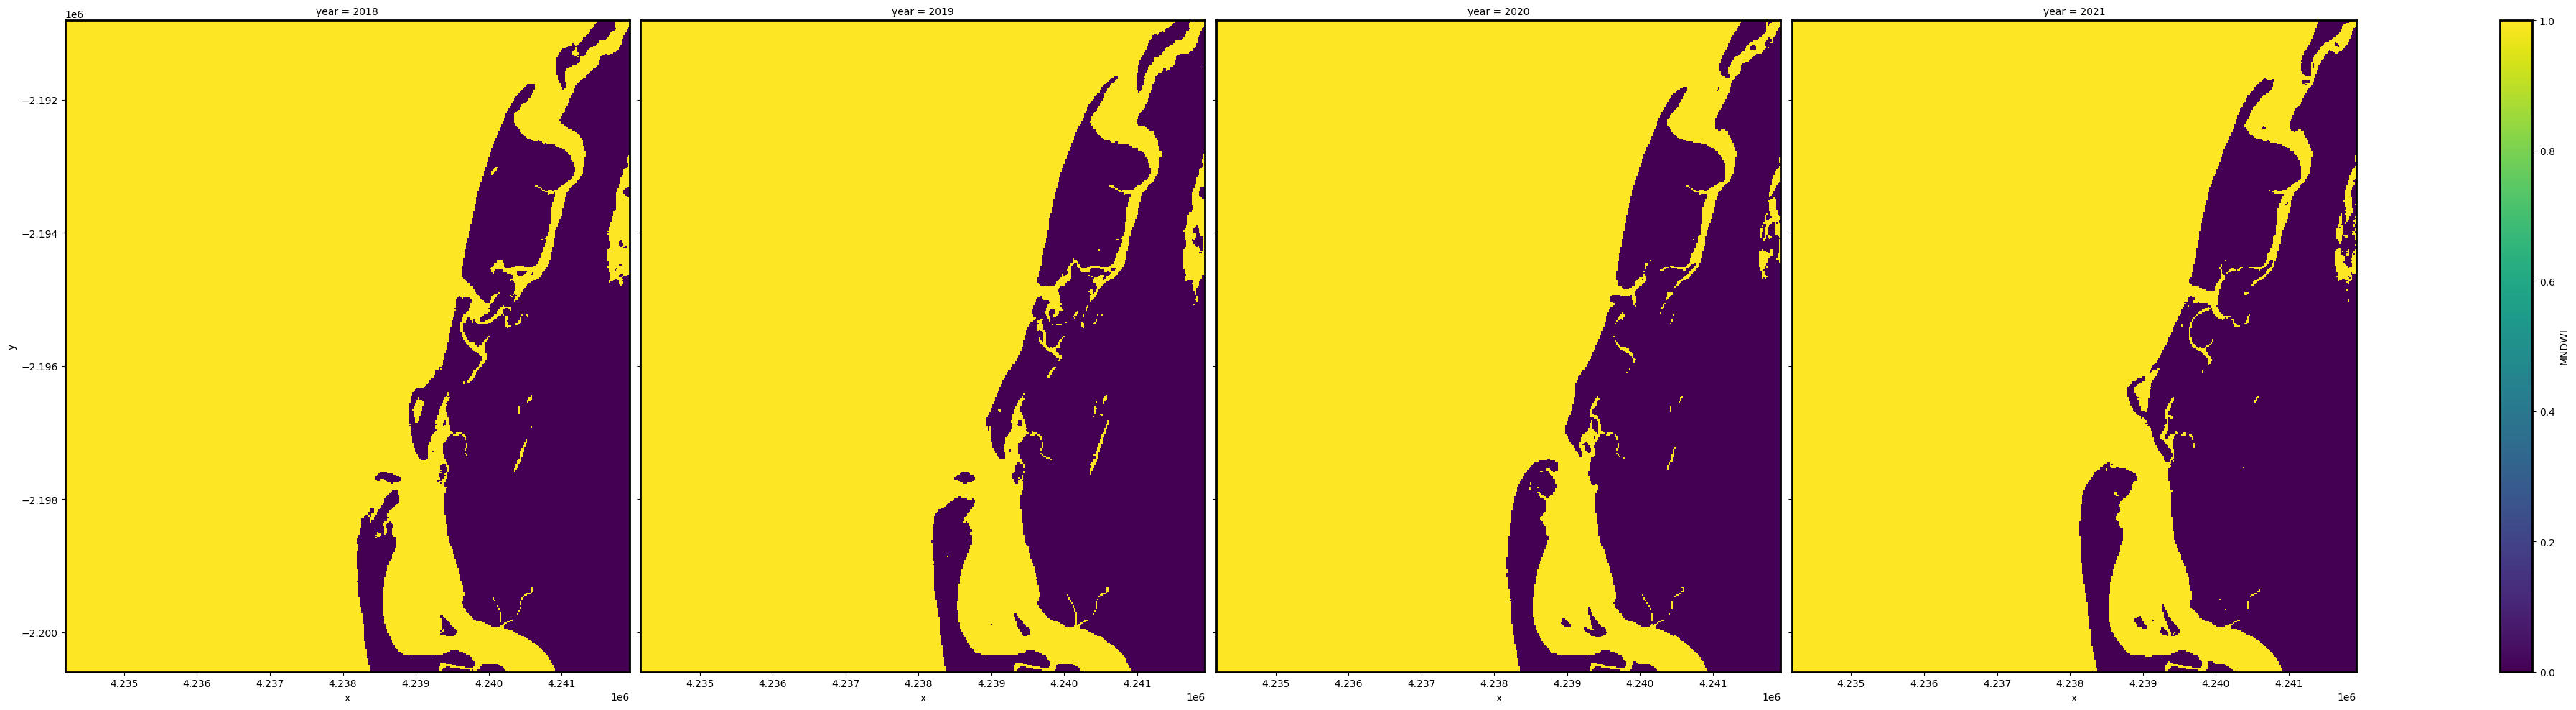

In [24]:
ds_summaries_s2_thresholded=ds_summaries_s2['MNDWI']>=0
ds_summaries_s2_thresholded.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)
plt.savefig('thresholding_s2_{}.png'.format(location_name))

## Accuracy assessment

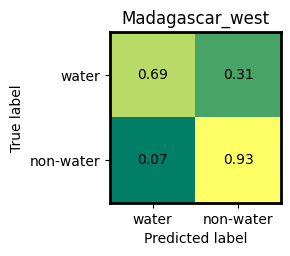

In [29]:
fig, ax = plt.subplots(figsize=(3,3))
# cm=confusion_matrix(labels, s1_median_vh<=threshold)
cm=confusion_matrix(labels, s1_median_vh<=threshold_roc)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im = ax.imshow(cm, cmap='summer')
for row in range(len(cm)):
    for col in range(len(cm)):
        value = "{:.2f}".format(cm[row, col])
        ax.text(col, row, value, ha='center', va='center', color='black')
ax.set_title(location_name)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
tick_labels = ['water','non-water']
ax.set_xticks(np.arange(len(tick_labels)))
ax.set_yticks(np.arange(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)
plt.tight_layout()
plt.show()

## Extract shorelines

### Extract shorelines from thresholding method

In [34]:
contour_gdf_thresholding=subpixel_contours(da=ds_summaries_s1.vh_med,
                                z_values=threshold_roc,
                                dim='year',
                                crs=ds_summaries_s1.geobox.crs,
                                output_path='annual_shorelines_S1_thresholding_{}.geojson'.format(location_name),
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S1_thresholding_Madagascar_west.geojson


### Extract shorelines from Sentinel-2 data (as reference)

In [32]:
contour_gdf_s2=subpixel_contours(da=ds_summaries_s2['MNDWI'],
                                z_values=0,
                                dim='year',
                                crs=ds_summaries_s1.geobox.crs,
                                output_path='annual_shorelines_S2_{}.geojson'.format(location_name),
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S2_Madagascar_west.geojson


### Plot annual shorelines on an interactive map

In [35]:
contour_gdf_thresholding.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [ ]:
contour_gdf_s2.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [37]:
# Shut down Dask client now that we have processed the data we need
client.close()